# Autograd
PyTorch的Autograd特性正是使得PyTorch在构建机器学习项目时既灵活又高效的关键之一。它允许对复杂计算过程中的多个偏导数（也称为梯度）进行快速且简便的计算。这一操作对于基于反向传播的神经网络学习至关重要。

Autograd的强大之处在于它能够在运行时**动态追踪**您的计算流程，这意味着即使模型中包含决策分支，或者循环的长度直到运行时才确定，计算流程仍会被正确追踪，从而确保获得正确的梯度以驱动学习过程。加之模型构建采用Python语言，这比依赖于静态分析、结构更为固定模型来计算梯度的框架提供了更大的灵活性。

简单来说，Autograd让PyTorch能够处理动态计算图，而不需要预先定义好计算流程，这为深度学习模型的设计和实验带来了极大的便利。

## 计算图
计算图（Computational Graphs）是一种描述运算的“语言”，它由节点(Node)和边(Edge)构成。

根据官网介绍，节点表示数据和计算操作，边仅表示数据流向。

### 叶子结点
叶子结点是最基础的结点，其数据不是由运算生成的，因此是整个计算图的基石，是不可轻易”修改“的。而最终计算得到的y就是根节点，就像一棵树一样，叶子在上面，根在下面。
![叶子结点](https://tingsongyu.github.io/PyTorch-Tutorial-2nd/chapter-2/imgs/comp-graph-2.png)

张量有一个属性是is_leaf, 就是用来指示一个张量是否为叶子结点的属性。

**非叶子结点在梯度反向传播结束后释放**，只有叶子节点的梯度得到保留，中间变量的梯度默认不保留；在pytorch中，非叶子结点的梯度在反向传播结束之后就会被释放掉，如果需要保留的话可以对该结点设置`retain_grad()`.

## 静态图与动态图
以上就是计算图的简单介绍。计算图根据计算图的搭建方式可以划分为静态图和动态图。

pytorch是典型的动态图，TensorFlow是静态图（TF 2.x 也支持动态图模式）。

动态图和静态图的搭建方式有何不同，如何判断和区分？

第一种判断：这就要看运算，是在计算图搭建之后，还是两者同步进行

先搭建计算图，再运算，这就是静态图机制。

而在运算的同时去搭建计算图，这就是动态图机制。

第二种判断：也可以通过判断运算过程中，计算图是否可变动来区分静态图与动态图。

在运算过程中，计算图可变动的是动态图；计算图不可变，是静止的，就是静态图。

下面来看两个示意图。

![动态图](https://tingsongyu.github.io/PyTorch-Tutorial-2nd/chapter-2/imgs/dynamic_graph.gif)
![静态图](https://tingsongyu.github.io/PyTorch-Tutorial-2nd/chapter-2/imgs/%E9%9D%99%E6%80%81%E5%9B%BE.gif)



## 我们为何需要Autograd？

一个机器学习模型是一个函数，具有输入和输出。在此讨论中，我们将输入视为i维向量 $\vec{x}$，其元素为 $x_i$。因此，我们可以将模型M表示为输入的矢量值函数：$\vec{y} = \vec{M}(\vec{x})$。（我们通常将M的输出值表示为矢量，因为通常情况下，模型可能有任意数量的输出。）

由于我们主要在训练背景下讨论Autograd，因此我们关注的输出将是模型的损失。**损失函数**$L(\vec{y}) = L(\vec{M}(\vec{x}))$是模型输出的单值标量函数。该函数**表达了我们的模型预测与特定输入的理想输出之间的偏差程度**。注：从这一点开始，当上下文清楚时，我们通常会省略矢量符号——例如，用 $y$ 而非 $\vec{y}$。

在训练模型时，我们的**目标是使损失最小化。理想情况下，这意味着调整模型的学习权重——即函数的可调参数——使得所有输入的损失都为零**。在现实世界中，这意味着一个迭代的过程，通过微调学习权重，直到我们看到对于各种输入，我们得到可以接受的损失。

我们**如何决定以多大的幅度以及朝哪个方向微调权重**？我们希望最小化损失，这意味着使损失关于输入的一阶导数等于0：$\frac{\partial L}{\partial x} = 0$。

然而，需要注意的是，损失并不是直接由输入衍生出来的，而是模型输出的一个函数（模型输出直接依赖于输入），$\frac{\partial L}{\partial x} = \frac{\partial L(\vec{y})}{\partial x}$。根据微积分中的链式法则，我们有 $\frac{\partial L(\vec{y})}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial M(x)}{\partial x}$。

$\frac{\partial M(x)}{\partial x}$ 这里事情变得复杂。模型输出关于其输入的偏导数，如果我们再次使用链式法则展开表达式，将涉及每个乘法学习权重、每个激活函数和模型中的每一个其他数学变换的局部偏导数。**对于试图计算一个参数的梯度，我们需要考虑所有从这个参数到损失函数的路径，并且沿着每条路径上的所有局部导数相乘，再将所有路径的结果相加起来。**

特别地，学习权重的梯度对我们来说很感兴趣——它们告诉我们应该朝哪个方向改变每个权重，以便使损失函数更接近于零。

由于这类局部导数的数量（每个对应模型计算图中的一条单独路径）往往会随着神经网络深度的增加而呈指数增长，因此计算它们的复杂性也随之增加。这就是Autograd发挥作用的地方：它追踪每一次计算的历史。**PyTorch模型中的每一个计算张量都携带了其输入张量和用于创建它的函数的历史信息。结合PyTorch中用于作用于张量的函数各自内置了计算自身导数的实现这一事实，这极大地加速了学习所需局部导数的计算。**

## 一个简单的例子

理论讲解了很多，但在实践中使用Autograd是什么样子的呢？

让我们从一个简单的例子开始。首先，我们将做一些导入工作，以便我们可以绘制结果图：（此部分描述未给出具体代码，但在实际操作中，这将涉及导入`matplotlib`等库，用于可视化数据和结果。）

这个例子将展示如何使用Autograd来计算一个简单函数的梯度，并通过可视化观察梯度的变化。接下来的部分将展示如何设置需要跟踪梯度的张量，执行计算，然后调用`.backward()`方法来计算梯度。我们还会演示如何从张量中读取这些梯度，以及如何使用这些信息来更新模型参数。这将帮助理解Autograd在实际机器学习任务中的应用 


In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

pytorch的自动求导机制特别依赖**tensor**的一个重要的属性，那就是`requires_grad = True`,有了这个属性就能够记录tensor的计算过程是怎么样的，从而实现计算的反向传播，下面通过一个正弦函数进行测试一下。另外，一个tensor的`requires_grad = True`,那么由它计算得到的tensor也为`True`

In [2]:
a = torch.linspace(0, 2*math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


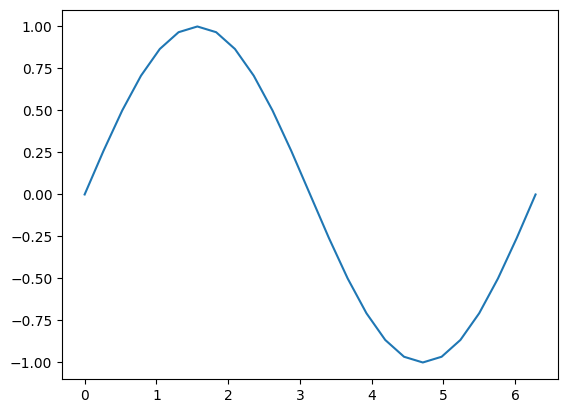

In [3]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

In [4]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


`grad_fn`这个属性相当于给了一个提示，记录了得到b这个tensor运算方式，在进行反向传播时候回根据提示函数进行求导

In [9]:
c = 2 * b
print(c)

d = c + 1 
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


In [10]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


In [11]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn.next_functions)
print(c.grad_fn.next_functions[0][0].next_functions)
print('\nb:')
print(b.grad_fn.next_functions)

d:
((<MulBackward0 object at 0x000001B927E8AF70>, 0), (None, 0))
((<SinBackward0 object at 0x000001B927E8AEB0>, 0), (None, 0))
((<AccumulateGrad object at 0x000001B927E8AF40>, 0),)
()

c:
((<SinBackward0 object at 0x000001B927E8A880>, 0), (None, 0))
((<AccumulateGrad object at 0x000001B927E8AF40>, 0),)

b:
((<AccumulateGrad object at 0x000001B927E8AFA0>, 0),)


在PyTorch中，`grad_fn.next_functions` 是一个列表，它存储了一个Tensor的梯度函数（`grad_fn`）的输入来源。当你对一个Tensor调用 `.backward()` 方法时，PyTorch会使用这个列表来追踪计算图，从而计算出所有需要的梯度。

`next_functions` 列表中的每个元素是一个元组，形式为 `(function, context)`。`function` 是指向下一个函数的引用，而 `context` 是一个整数值，表示在计算图中这个函数的输入来源的索引。`context` 通常是用来解决函数有多个输入的情况，以区分不同的输入源。

当你看到 `grad_fn.next_functions[0][0]`，这实际上是在访问计算图中当前 `grad_fn` 的第一个输入函数。具体来说：

- `grad_fn` 指的是当前Tensor的梯度函数，它记录了如何计算当前Tensor的梯度。
- `next_functions` 是一个列表，它包含了所有输入到当前梯度函数的前向函数。
- `[0]` 表示我们正在访问这个列表中的第一个元素，也就是第一个输入函数。
- `[0]` 再次出现是为了获取这个元组中的第一个元素，即函数本身。

例如，如果你有一个操作序列 `a -> b -> c`，其中 `c = b + d`，`b = a * e`，那么在 `c` 的计算图中，`c.grad_fn.next_functions` 将包含指向 `b` 的梯度函数的信息，而 `b.grad_fn.next_functions` 将包含指向 `a` 的梯度函数的信息。所以，如果你在 `c` 上调用 `.backward()`，PyTorch会先计算 `c` 关于 `b` 和 `d` 的梯度，然后沿着计算图回溯，计算 `b` 关于 `a` 和 `e` 的梯度，以此类推。

总之，`grad_fn.next_functions[0][0]` 是用于在计算图中向前追溯，找到计算当前Tensor的梯度所需的下一个函数的引用。这是PyTorch自动计算梯度的核心机制之一，使得用户无需手动实现复杂的链式法则，大大简化了深度学习模型的训练过程。

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


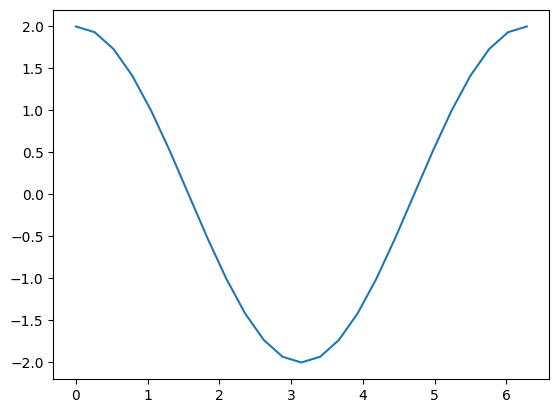

In [28]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

导数推导:
$
\frac{dout}{da} = \frac{dout}{dd} \cdot \frac{dd}{dc} \cdot \frac{dc}{db} \cdot \frac{db}{da}
$
$
\frac{dout}{da} = 1 \cdot 1 \cdot 2 \cdot \cos(a) = 2\cos(a)
$
## 模型训练中的自动求导
让我们定义一个小型模型，并观察它在经过单个训练批次后如何变化。首先，定义几个常量，模型，以及一些输入和输出的替代品

In [12]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        
        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

我们这里没有修改模型layers层中的`requires_grad=True`，这是因为`torch.nn.Module`的子类默认为会我们想追踪layers的权重的梯度进行学习。

如果想查看模型中各个layers，我们可以检查各个layer的权重的值，并验证其是否具有**梯度**

In [14]:
print(model.layer1.weight.shape)
print(model.layer1.weight[0][:10])
print(model.layer1.weight.grad)

torch.Size([100, 1000])
tensor([ 0.0140,  0.0157, -0.0059,  0.0126,  0.0226,  0.0157, -0.0233, -0.0245,
         0.0218,  0.0206], grad_fn=<SliceBackward0>)
None


下面看下是权重是如何通过训练一个批次进行改变的，优化器选择随机梯度下降优化器，`loss`选择平方差距离损失

In [104]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)
loss = (prediction - ideal_output).pow(2).sum()
print(loss)

tensor(230.0357, grad_fn=<SumBackward0>)


下面进行反向传播看看有什么变化，可以看到，**运用`loss.backward()`对于每个权重参数的梯度计算出来了**

In [105]:
loss.backward()
print(model.layer1.weight[0][:10])
print(model.layer1.weight.grad[0][:10])

tensor([-0.0234, -0.0035, -0.0090, -0.0141,  0.0287, -0.0020,  0.0290, -0.0065,
         0.0080,  0.0165], grad_fn=<SliceBackward0>)
tensor([ 0.4365, -1.0308,  1.2291, -0.1205, -1.1641,  0.4009, -1.6160,  0.7230,
         0.9217, -0.5220])


然后使用优化器，对每个参数进行优化

In [106]:
optimizer.step()
print(model.layer1.weight[0][:10])
print(model.layer1.weight.grad[0][:10])

tensor([-0.0238, -0.0025, -0.0102, -0.0139,  0.0299, -0.0024,  0.0306, -0.0073,
         0.0071,  0.0170], grad_fn=<SliceBackward0>)
tensor([ 0.4365, -1.0308,  1.2291, -0.1205, -1.1641,  0.4009, -1.6160,  0.7230,
         0.9217, -0.5220])


很明显能够看到，`layer1`层的权重参数发生了变化

**一个重要的事情：在每次执行完`optimizer.step()`后，必须执行`optimizer.zero_grad()`，否则的话每执行一次`loss.backward()`，那么梯度就会在`optimizer`中累加，下面举例说明**

In [107]:
print(model.layer1.weight.grad[0][:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (prediction - ideal_output).pow(2).sum()
    loss.backward()
    
print(model.layer1.weight.grad[0][:10])

optimizer.zero_grad()

print(model.layer1.weight.grad)

tensor([ 0.4365, -1.0308,  1.2291, -0.1205, -1.1641,  0.4009, -1.6160,  0.7230,
         0.9217, -0.5220])
tensor([ 1.3251,  0.1537,  4.6662, -2.2890, -1.3846,  0.6641, -4.9433,  2.0040,
         3.8901,  1.6731])
None


## Autograd开关
在某些特殊的情况需要对是否开启自动求导进行细微的控制，一种最简单的方法就是对`requires_grad`进行设置，下面是一些实例

In [108]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


如果只是暂时想关闭autograd，一种更好的方式是`torch.no_grad()`:

In [109]:
a = torch.ones(2, 3, requires_grad = True) * 2
b = torch.ones(2, 3, requires_grad = True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b
print(c2)

c3 = a + b 
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)


`torch.no_grad()`:也能够做函数或者方法修饰器

In [111]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y

a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


与`torch.no_grad()`相对应的PyTorch 中的一个上下文管理器(context manager)是`torch.enable_grad()`，用于在没打开autograd时候使用。它同样能够作为修饰器来使用

最后，如果想要一个`Tensor`的副本，但是又不需要跟踪这个`Tensor`的计算历史，可以使用`detach()`方法，使得其与计算历史分离，**仅仅获得这个`Tensor`。**

In [112]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.5199, 0.9228, 0.6997, 0.1276, 0.6876], requires_grad=True)
tensor([0.5199, 0.9228, 0.6997, 0.1276, 0.6876])


在想绘制tensor图形的时候，我们必须这样做，因为`matplotlib`期望一个Numpy数组作为输入，**如果`requires_grad = True`的时候，那么就不能完成`Tensor`到`numpyarray`的隐形转换**。

### 自动求导与就地操作（in-place operations）

在本笔记中的每一个示例中，我们都使用变量来捕获计算过程中的中间值。自动求导（Autograd）需要这些中间值来进行梯度计算。*因此，在使用自动求导时，你必须小心对待就地操作（in-place operations）*。执行就地操作可能会破坏你在 `backward()` 调用中需要的信息，
用于计算导数。PyTorch 甚至会阻止你在一个需要自动求导的叶节点变量上执行就地操作，如下所示的例子所展示。

*注：下面的代码单元格会抛出一个运行时错误。这是预期的行为。*
___
在PyTorch中，就地操作是指那些修改原始张量的操作，而不是返回一个新的张量。例如，`tensor.add_(other)` 是一个就地操作，它直接在 `tensor` 上修改其值，而 `tensor + other` 则不是就地操作，因为它返回一个新的张量而不改变原张量。

在使用自动求导时，避免就地操作的原因是这样的操作可能破坏计算图的完整性。计算图依赖于所有操作的记录，以便在反向传播时能够正确地追踪梯度。一旦执行了就地操作，计算图可能丢失关于该操作的信息，从而无法正确地计算梯度。

为了避免这种问题，PyTorch 会对就地操作进行限制，特别是在涉及需要梯度的叶节点变量时。如果在需要梯度的变量上执行就地操作，PyTorch 会抛出异常，提示用户更改代码以避免此类操作。这有助于保持计算图的完整性和梯度计算的准确性。

In [115]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
torch.sin_(a)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

## 自动求导（Autograd）简介与Profiler使用
自动求导（Autograd）是PyTorch中的一个核心模块，它负责自动计算张量操作的梯度。Autograd不仅能够记录每一次的计算步骤，还能结合时间信息，这使其成为一个非常实用的性能分析工具，即Profiler。

Profiler可以帮你追踪模型训练过程中的每一步计算，包括每个操作的时间消耗，这对于优化模型和识别瓶颈非常有帮助。下面是一个快速示例，展示如何使用Autograd的Profiler功能：

In [15]:
import torch
import torch.autograd.profiler as profiler
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True
    
x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with profiler.profile(use_cpu=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y

print(prf.key_averages().table(sort_by='self_cpu_time_total'))



-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::div        52.46%       9.352ms        52.46%       9.352ms       9.352us          1000  
    aten::mul        47.54%       8.475ms        47.54%       8.475ms       8.475us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 17.827ms



## 高级主题：更多 Autograd 细节和高级 API

如果你有一个 n 维输入和 m 维输出的函数，$\vec{y}=f(\vec{x})$，那么完整的梯度是每个输出对每个输入的导数矩阵，称为*雅可比矩阵（Jacobian）：*

$$
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{array}\right)
$$

如果你有第二个函数，$l=g\left(\vec{y}\right)$，该函数接受 m 维输入（即与上述输出的维度相同），并返回标量输出，你可以将其相对于 $\vec{y}$ 的梯度表示为列向量，$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$ - 这实际上只是一个一列的雅可比矩阵。

更具体地说，假设**第一个函数是你的 PyTorch 模型（可能有许多输入和许多输出），第二个函数是损失函数（模型的输出作为输入，损失值作为标量输出）。**

如果我们将第一个函数的雅可比矩阵乘以第二个函数的梯度，并应用链式法则，我们得到：

$$
J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
\end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
\end{array}\right)
$$

*注意：你也可以使用等效的操作 $v^{T}\cdot J$，并返回一个行向量。*

结果的列向量是*第二个函数相对于第一个函数输入的梯度* - 或者**在我们的模型和损失函数的情况下，是损失相对于模型输入的梯度。**

**`torch.autograd` 是一个计算这些乘积的引擎。** 这就是我们在反向传播过程中积累学习权重梯度的方式。

因此，`backward()` 调用还可以接受一个可选的向量输入。这个向量表示张量上的一组梯度，这些梯度乘以前面 autograd 跟踪张量的雅可比矩阵。让我们尝试用一个小向量来做一个具体的例子。


In [16]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([1359.8547, -228.2667, -386.9629], grad_fn=<MulBackward0>)


In [17]:
y.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

如果我们现在尝试调用`y.backward()`，会得到一个运行时错误，并提示只有对标量（scalar）输出才能隐式计算梯度。这意味着`backward()` 方法只能直接用于标量输出(**即单个值**)，而不能直接用于多维（例如向量或矩阵）输出。
对于多维输出（例如向量 y），`autograd`期望我们提供这些输出的梯度，以便它可以将这些梯度与*雅可比矩阵（Jacobian）相乘*
。可比矩阵是包含所有输出相对于输入的导数的矩阵。对于一个多维输出 y，`y.backward()` 需要一个与 y 形状相同的梯度向量作为输入，这个梯度向量表示每个输出元素的梯度。

In [156]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


（请注意，输出的梯度都与2的幂相关，这是我们从重复加倍操作中预期的结果。）

### 高级 API
autograd 提供了一个高级 API，使你可以直接访问重要的微分矩阵和向量操作。具体来说，它允许你计算特定函数在特定输入下的雅可比矩阵和黑塞矩阵（Hessian）。黑塞矩阵类似于雅可比矩阵，但表示所有二阶偏导数。它还提供了使用这些矩阵进行向量乘积的方法。

让我们对一个简单函数进行雅可比矩阵的计算，针对两个单元素输入进行评估：

In [157]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.9433]), tensor([0.3910]))


(tensor([[5.1369]]), tensor([[3.]]))

如果仔细观察，第一个输出应等于 \( 2e^x \)（因为 \( e^x \) 的导数是 \( e^x \)），第二个值应为 3。

当然，你也可以对高阶张量执行此操作：

In [158]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.7147, 0.9901, 0.2233]), tensor([0.4349, 0.1274, 0.0035]))


(tensor([[4.0870, 0.0000, 0.0000],
         [0.0000, 5.3829, 0.0000],
         [0.0000, 0.0000, 2.5003]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

`torch.autograded.functional.hessian()`方法的工作方式相同(假设您的函数是两次可微的)，但返回所有二阶导数的矩阵。

如果提供向量，还有一个函数可以直接计算向量-雅可比乘积:

In [159]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([-1209.9866,   -57.1409,  -602.5959]),
 tensor([1.0240e+02, 1.0240e+03, 1.0240e-01]))

`torch.autograd.functional.jvp()` 方法执行与 `vjp()` 相同的矩阵乘法，但操作数相反。`vhp()` 和 `hvp()` 方法对向量-黑塞矩阵乘积执行相同的操作。

要了解更多信息，可以查阅官方文档[docs for the functional API](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)

## 高级主题:高阶导数
+ 使用更高级的api计算自己的链式法则导数